# **>>> 😀 Performing Multipose Estimation using MoveNet Model, present on TF Hub...**
# **[ https://tfhub.dev/google/movenet/multipose/lightning/1 ].**

## 🛍️ Here, I've taken the example of Performing MultiPose Estimation in 🏪 Grocery Store to determine Movements of the customer in Store, for ex. Tracking the Customer(hand or any other) movements.

In [ ]:
"""

>>> Performing in Spyder IDE:)

"""

# let's do the required imports
import tensorflow as tf
import tensorflow_hub as hub
import cv2
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Load the MoveNet MutiPose Model from Tensorflow-Hub
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')

# Store the 'serving_default' signature of model object in the 'movenet' variable.
movenet = model.signatures['serving_default']

"""The 'serving_default' signature is the pre-trained model that can be used to detect and track multiple people in a video."""


# 1. Creating the instance of VideoCapture for capturing the video
cap = cv2.VideoCapture('multi_pose_estimation_video_footage_1-3840x2160-50fps.mp4')

# 2. Let's define the Window and it's size
cv2.namedWindow('MultiPose Estimation', cv2.WINDOW_NORMAL)
window_width = 1080
window_height = 720
cv2.resizeWindow("MultiPose Estimation", window_width, window_height)



""" <<<<<<<<<< Functions to Define >>>>>>>>> """
# Now let's draw the keypoints
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape    # grabbing y, x and channel coordinate
    shaped = np.squeeze(np.multiply(keypoints, [y, x, 1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 20, (0, 255, 0), -8)
           
            
"""
The order of the 17 keypoint joints is:
    [nose, left eye, right eye, left ear, right ear, left shoulder, right shoulder, left elbow, right elbow, left wrist, right wrist, left hip, right hip, left knee, right knee, left ankle, right ankle].
"""
# Now let's draw the edges
EDGES = {
    (0, 1): 'm',    # nose connected to left-eye
    (0, 2): 'c',    # nose connected to right-eye
    (1, 3): 'm',    # left-eye connected to left-ear
    (2, 4): 'c',    # right-eye connected to right-ear
    (0, 5): 'm',    # nose connected to left-shoulder
    (0, 6): 'c',    # nose connected to right-shoulder
    (5, 7): 'm',    # left-shoulder connected to left-elbow
    (7, 9): 'm',    # left-elbow connected to left-wrist
    (6, 8): 'c',    # right-shoulder connected to right-elbow
    (8, 10): 'c',   # right-elbow connected to right-wrist
    (5, 6): 'y',    # left-shoulder connected to right-shoulder
    (5, 11): 'm',   # left-shoulder connected to left-hip
    (6, 12): 'c',   # right-shoulder connected to right-hip
    (11, 12): 'y',  # left-hip connected to right-hip
    (11, 13): 'm',  # left-hip connected to left-knee
    (13, 15): 'm',  # left-knee connected to left-ankle
    (12, 14): 'c',  # right-hip connected to right-knee
    (14, 16): 'c'   # right-knee connected to right-ankle
}


# Now let's draw the connections...
def draw_connections(frame, keypoints, edges, confidence_threshold):
    """This function is set-up to handle 1 person at the moment"""
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y, x, 1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 0), 12)
    

# Now let's create a function to loop through each person detected and render
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold):
    for person in keypoints_with_scores:
        draw_connections(frame, person, edges, confidence_threshold)
        draw_keypoints(frame, person, confidence_threshold)



# Looping over to each frame in a video
while True:
    ret, frame = cap.read()
    
    print("\n ----> Shape of the Frame is:", frame.shape)

    # if suppose some frame does not get captured / not returned then break the loop
    if not ret:
        break
    
    # We're going to make detections using resized image, but we will render using same size image, so we need to make copy of our image.
    img = frame.copy()
    
    # resize the image to 256 x 256 as mentioned in MoveNet Documentation on TensorFlow Hub!
    img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 160, 288)
    
    # Cast the image to 'int32' data type
    input_img = tf.cast(img, dtype=tf.int32)
    
    """
    The tf.image.resize_with_pad() function takes 3 arguments.
    1. The image to be resized.
    2. The Desired Width.
    3. The Desired Height.
    """

    # Now let's detect on image
    results = movenet(input_img)
    print("\n <<< Results of MoveNet Model: >>>\n", results)
    
    keypoints_with_scores = results['output_0'].numpy()[:, :, :51].reshape((6, 17, 3))
    """6 people by 17 keypoints by 3 values for each keypoint"""
    
    print(keypoints_with_scores)
    
    # To grab the 1st person keypoints...
    print("\n===== Grabbing first person keypoints: =====\n", keypoints_with_scores[0])
    
    """
    In Output: 
    [[0.46418357 0.50974846 0.7170741]
    [0.4048354  0.5592801  0.6778678 ]
    [0.40929303 0.45156673 0.5932613 ]
    [0.42737398 0.62041515 0.74552804]
    [0.43918663 0.39505535 0.702723  ]
    [0.6212135  0.7476057  0.70804447]
    [0.6362618  0.2695415  0.77151847]  Till here, these coordinates are higher because they are the one that are shown on the screen(upper part of the body)
    
    From here, we're getting lower confidence score(3rd value in list) because that is the lower part of the body..
    [0.86889774 0.77923095 0.213031  ]  
    [0.88065195 0.20989811 0.08886088]
    [0.8476411  0.68860364 0.27131107]
    [0.8540766  0.36495042 0.05892986]
    [0.8801366  0.6350781  0.00738304]
    [0.8758316  0.39470017 0.01484372]
    [0.82039607 0.7529023  0.02127612]
    [0.7955929  0.29581624 0.01065289]
    [0.6319317  0.52078944 0.00174756]
    [0.57099545 0.50971234 0.00486571]]
    """
    
    # Render Keypoints
    loop_through_people(frame, keypoints_with_scores, EDGES, 0.1)
    
    # now, let's create an empty image, for drawing the keypoints and it's connections on one blank screen.
    h, w, c = frame.shape
    output_img = np.zeros([640, 1080, c])
    
    # fill the pixels with white(255)
    output_img.fill(255)
    
    # let's define the grid parameters for drawing the grid...
    num_rows = 50
    num_cols = 50
    
    for i in range(1, num_rows):
        cv2.line(output_img, (0, i * h //  num_rows), (w, i * h // num_rows), (0,0,0), 1)
    
    for i in range(1, num_cols):
        cv2.line(output_img, (i * w // num_cols, 0), (i * w // num_cols, h), (0, 0, 0), 1)

    # Eventually let's render that keypoints and connections on blank image as well...
    loop_through_people(output_img, keypoints_with_scores, EDGES, 0.1)
        
    # Show the image or frame in a particular window
    cv2.imshow('MultiPose Estimation', frame)
    
    # Showing that blank image on which the keypoints and connections will be rendered...
    cv2.imshow("Extracted MultiPose Estimation", output_img)

    #stop the execution on pressing the escape key on keyboard
    if cv2.waitKey(1) == 27:
        break

cap.release()
cv2.destroyAllWindows()

# to know themm shape, let's print out the image
print(frame)

# let's plot the image using matplotlib
# plt.imshow(frame)
plt.imshow(output_img)

# Now when we go and access our image from opencv, it's going to read in as BGR and matplotlib goes in RGB
# plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))


# <--------------------------------------------------------------------------------------->

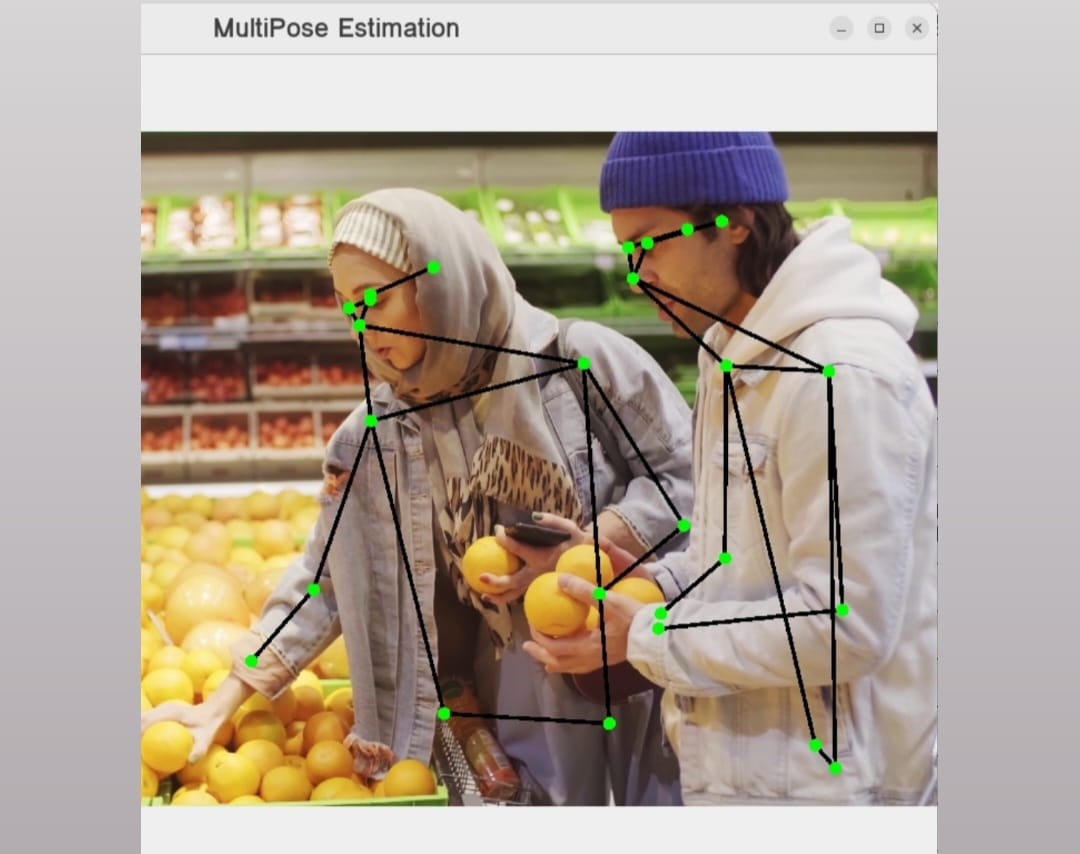
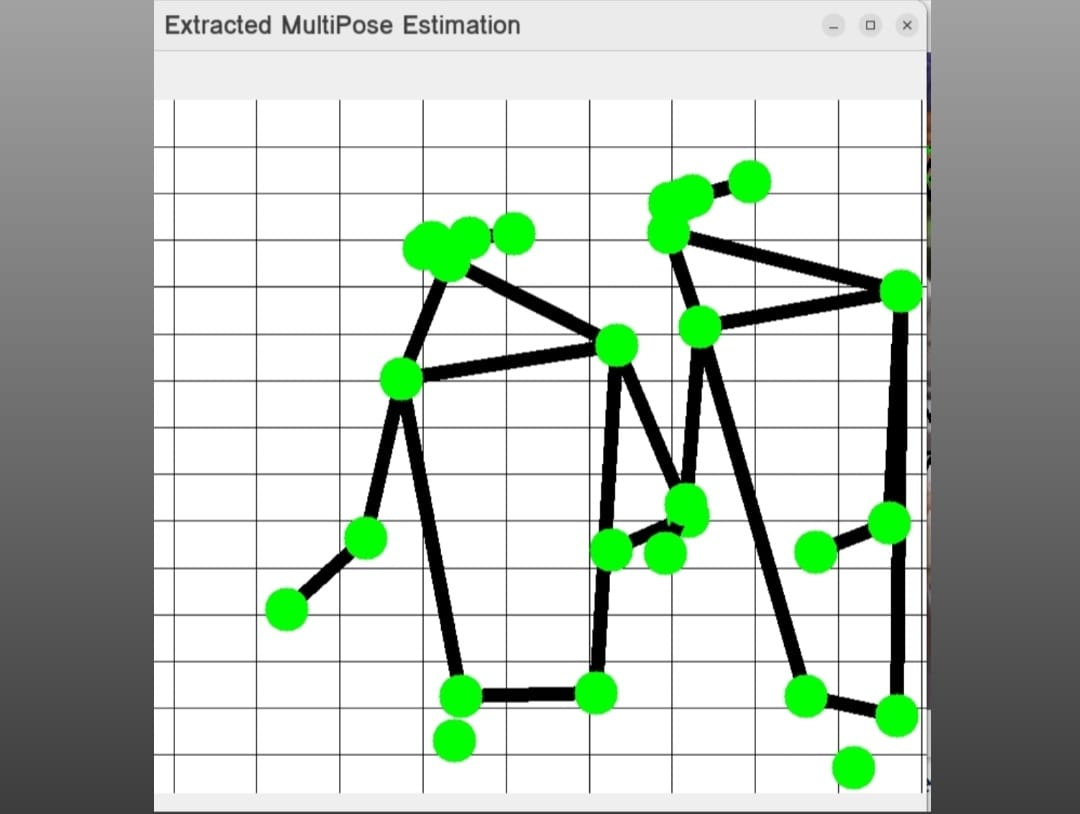

## **Hence, this is the way we can track the customer Movements in a Grocery Store :)**